In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-901/jini...png
/kaggle/input/butter/Butterfly.jpg
/kaggle/input/sampleimage/Screenshot 2024-09-16 153207.png
/kaggle/input/simplebutter/Simplebutter.png


Iteration 0, Loss: 11638017.070221309
Iteration 1000, Loss: 206.38169387075553
Iteration 2000, Loss: 90.46642717553009
Iteration 0, Loss: 11665126.71144303
Iteration 1000, Loss: 198.55921705147824
Iteration 2000, Loss: 92.36523125135515
Iteration 0, Loss: 11614950.61405154
Iteration 1000, Loss: 186.88203422717314
Iteration 2000, Loss: 80.94905837853311
Iteration 0, Loss: 11654540.059054902
Iteration 1000, Loss: 12.205878799749144
Iteration 2000, Loss: 0.15613278655816032
Matrix Factorization - RMSE: 0.042599547654390335, PSNR: 27.411900249046653 dB
RFF + Linear Regression - RMSE: 0.015788722783327103, PSNR: 36.03306000982546 dB


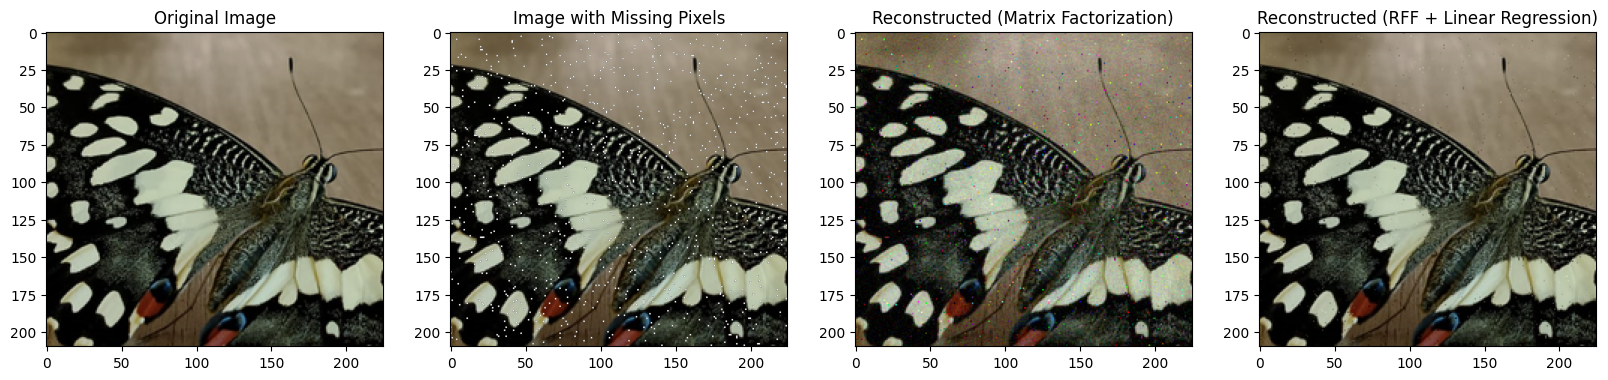

Iteration 0, Loss: 11447301.76690811
Iteration 1000, Loss: 215.5468582845638
Iteration 2000, Loss: 85.3233084028229
Iteration 0, Loss: 11479739.476417901
Iteration 1000, Loss: 226.8503202112375
Iteration 2000, Loss: 88.51482099417004
Iteration 0, Loss: 11592321.11606208
Iteration 1000, Loss: 190.011900447391
Iteration 2000, Loss: 76.51351931356456
Iteration 0, Loss: 11591908.464234844
Iteration 1000, Loss: 51.17918794762386
Iteration 2000, Loss: 1.5260069732041366
Matrix Factorization - RMSE: 0.06388561427593231, PSNR: 23.891938500039494 dB
RFF + Linear Regression - RMSE: 0.02385467104613781, PSNR: 32.448531358946354 dB


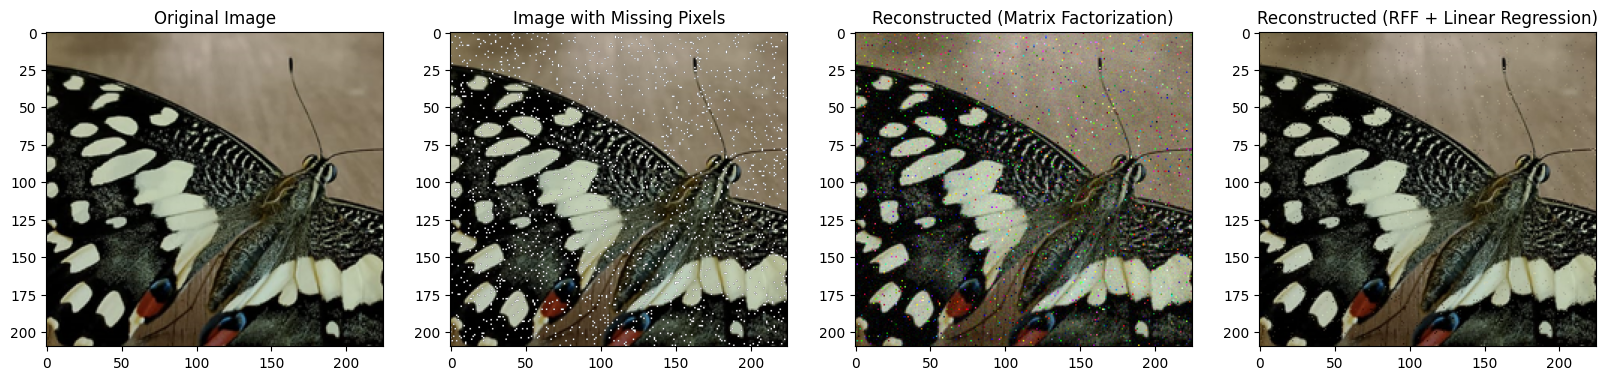

Iteration 0, Loss: 11150323.499120498
Iteration 1000, Loss: 226.11867971071163
Iteration 2000, Loss: 71.20894829930045
Iteration 0, Loss: 10938690.090442546
Iteration 1000, Loss: 218.1276030034042
Iteration 2000, Loss: 74.79811540940577
Iteration 0, Loss: 11033489.769234307
Iteration 1000, Loss: 219.631660029363
Iteration 2000, Loss: 67.72308090933329
Iteration 0, Loss: 11271811.597364662
Iteration 1000, Loss: 130.9562902274671
Iteration 2000, Loss: 10.697641991896052
Matrix Factorization - RMSE: 0.09820514917373657, PSNR: 20.157314806559896 dB
RFF + Linear Regression - RMSE: 0.028762733563780785, PSNR: 30.82339683361989 dB


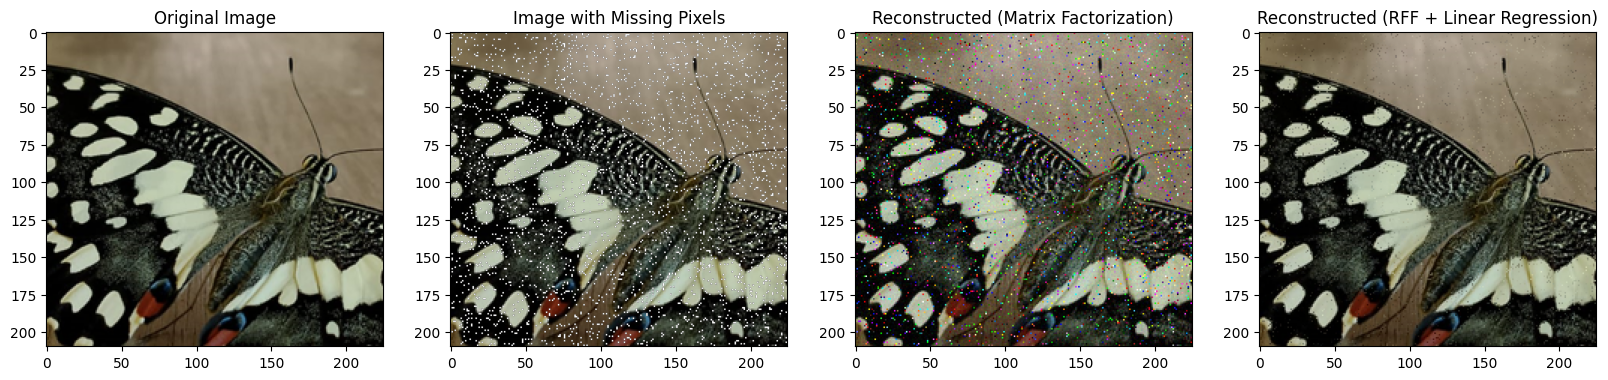

In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


img_path = '/kaggle/input/simplebutter/Simplebutter.png'  
img = torchvision.io.read_image(img_path).float() / 255.0  # Normalize between 0 and 1

img = img.to(device)

height, width = img.shape[1], img.shape[2]
def final(removed_pixel):
    # Step 1: Randomly remove 900 pixels
    missing_mask = np.ones((height, width))
    missing_pixels = np.random.choice(height * width, removed_pixel, replace=False)
    missing_mask.flat[missing_pixels] = 0  

    img_masked = img.clone()
    for c in range(img.shape[0]):  # Loop over RGB channels
        img_masked[c, :, :] *= torch.tensor(missing_mask).to(device)

    # Define the matrix factorization function
    def factorize_channel(channel, mask, r, lr=0.01, num_iters=3000):
        h, w = channel.shape

        # Initialize W (h x r) and H (r x w) randomly
        W = torch.randn(h, r, requires_grad=True, device=device)
        H = torch.randn(r, w, requires_grad=True, device=device)

        # Optimizer
        optimizer = torch.optim.Adam([W, H], lr=lr)

        # Train the model
        for i in range(num_iters):
            optimizer.zero_grad()

            # Reconstructed image
            reconstructed_channel = torch.mm(W, H)

            # Apply mask: consider only the known pixels during training
            loss = torch.norm((reconstructed_channel - channel) * mask, 'fro') ** 2

            # Backpropagation
            loss.backward()
            optimizer.step()

            if i % 1000 == 0:
                print(f"Iteration {i}, Loss: {loss.item()}")

        return W, H

    # Factorize each channel using the masked image
    reconstructed_channels_mf = []

    for c in range(img.shape[0]):
        channel = img[c, :, :]
        mask = torch.tensor(missing_mask).to(device)  # Use the mask for missing pixels
        W, H = factorize_channel(channel, mask, r=250)
        reconstructed_channel = torch.mm(W, H).cpu().detach().numpy()
        reconstructed_channels_mf.append(reconstructed_channel)

    # Stack the reconstructed channels back into an RGB image (Matrix Factorization)
    reconstructed_img_mf = np.stack(reconstructed_channels_mf, axis=0)
    reconstructed_img_mf = np.clip(reconstructed_img_mf, 0, 1)  # Clip to valid range
    reconstructed_img_mf = np.transpose(reconstructed_img_mf, (1, 2, 0))

    # Step 2: Random Fourier Features (RFF) + Linear Regression
    def rff_reconstruct(img, mask, gamma=0.05, n_components=1000):
        """Reconstruct missing pixels using RFF + Linear Regression."""
        height, width = img.shape[1], img.shape[2]
        X_known = np.argwhere(mask == 1)
        X_missing = np.argwhere(mask == 0)

        # Flatten image for easy access
        img_flattened = img.reshape(img.shape[0], -1)

        reconstructed_channels_rff = []

        for c in range(img.shape[0]):  # Loop over channels (R, G, B)
            y_known = img_flattened[c, X_known[:, 0] * width + X_known[:, 1]]

            # Apply RFF to known pixel positions
            rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=1)
            X_transformed = rbf_feature.fit_transform(X_known)
            X_missing_transformed = rbf_feature.transform(X_missing)

            # Train linear regression
            model = Ridge(alpha=1.0)
            model.fit(X_transformed, y_known)

            # Predict missing pixel values
            y_missing = model.predict(X_missing_transformed)

            # Reconstruct image
            img_reconstructed = img_flattened[c, :].copy()
            img_reconstructed[X_missing[:, 0] * width + X_missing[:, 1]] = y_missing
            reconstructed_channels_rff.append(img_reconstructed.reshape(height, width))

        reconstructed_img_rff = np.stack(reconstructed_channels_rff, axis=0)
        return np.clip(reconstructed_img_rff, 0, 1)  # Clip to valid range

    reconstructed_img_rff = rff_reconstruct(img_masked.cpu().numpy(), missing_mask)
    reconstructed_img_rff = np.transpose(reconstructed_img_rff, (1, 2, 0))

    # RMSE and PSNR calculations
    def calculate_rmse(original, reconstructed):
        return np.sqrt(np.mean((original - reconstructed) ** 2))

    def calculate_psnr(original, reconstructed):
        mse = np.mean((original - reconstructed) ** 2)
        max_pixel = 1.0  # Since the image is normalized between 0 and 1
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
        return psnr

    # Convert original image to CPU for RMSE/PSNR calculations
    original_img = img.cpu().detach().numpy()
    original_img = np.transpose(original_img, (1, 2, 0))

    # Calculate RMSE and PSNR for Matrix Factorization
    rmse_mf = calculate_rmse(original_img, reconstructed_img_mf)
    psnr_mf = calculate_psnr(original_img, reconstructed_img_mf)

    # Calculate RMSE and PSNR for RFF + Linear Regression
    rmse_rff = calculate_rmse(original_img, reconstructed_img_rff)
    psnr_rff = calculate_psnr(original_img, reconstructed_img_rff)

    print(f"Matrix Factorization - RMSE: {rmse_mf}, PSNR: {psnr_mf} dB")
    print(f"RFF + Linear Regression - RMSE: {rmse_rff}, PSNR: {psnr_rff} dB")

    # Plot the original, masked, and reconstructed images
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[1].imshow(np.transpose(img_masked.cpu().detach().numpy(), (1, 2, 0)))
    ax[1].set_title('Image with Missing Pixels')
    ax[2].imshow(reconstructed_img_mf)
    ax[2].set_title('Reconstructed (Matrix Factorization)')
    ax[3].imshow(reconstructed_img_rff)
    ax[3].set_title('Reconstructed (RFF + Linear Regression)')
    plt.show()
final(900)
final(2000)
final(3000)


Iteration 0, Loss: 6147345.667757448
Iteration 1000, Loss: 381.433720033174
Iteration 2000, Loss: 175.54343995985926
Iteration 0, Loss: 6165917.565848794
Iteration 1000, Loss: 415.6690276956787
Iteration 2000, Loss: 200.20539186461906
Iteration 0, Loss: 6334605.789736351
Iteration 1000, Loss: 377.0635791597069
Iteration 2000, Loss: 180.08282768125113
Iteration 0, Loss: 6054703.65432946
Iteration 1000, Loss: 9.676523423767609
Iteration 2000, Loss: 0.21682112786973207
Matrix Factorization - RMSE: 0.07417594641447067, PSNR: 22.594738075831422 dB
RFF + Linear Regression - RMSE: 0.040139783173799515, PSNR: 27.928499556092106 dB


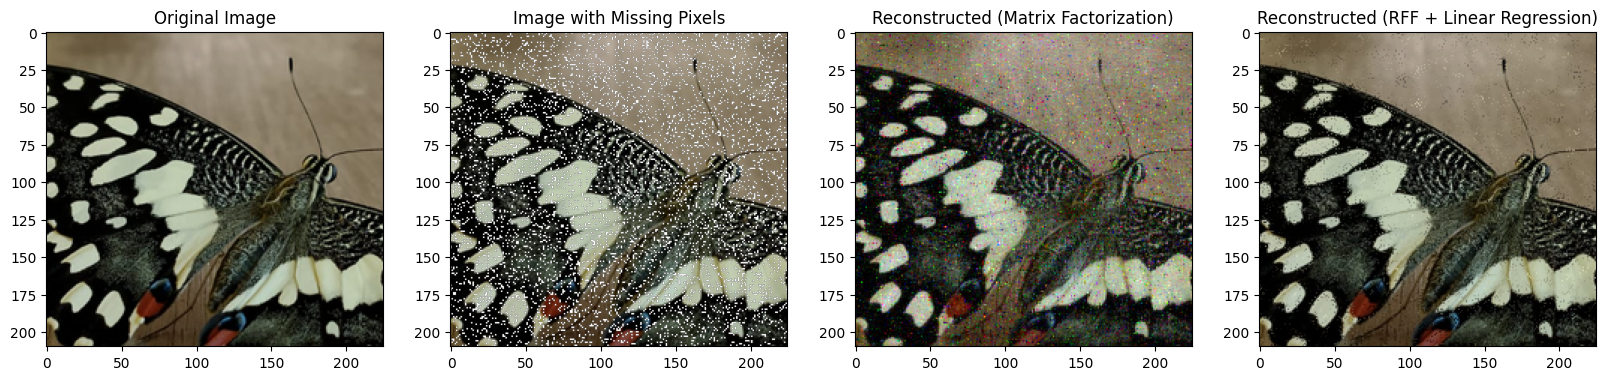

In [10]:
final(6000)

we reeocnstructed image for 900,1000,2000,6000 removed pixels, and when we reconstruct image using matrix factorization, error is larger then RFF reconstruction. Reason behind it is that Matrix factorization works more well for local pattern, however RFF works well with both Local and Global pattern. So RFF rmse is less then Matrix, but it changes as we increase removed pixel. As we changed from 900 to 6000 removed pixel, change in rmse for Matrix is less then RFF, so when number of missing pixels are larger, then Matrix might perform well.

Iteration 0, Loss: 60608883.467160955
Iteration 1000, Loss: 1142.437662655661
Iteration 2000, Loss: 524.6221598958809
Iteration 3000, Loss: 361.2381231609965
Iteration 4000, Loss: 272.3377061711411
Iteration 5000, Loss: 201.79731296883048
Iteration 6000, Loss: 145.6525602785103
Iteration 0, Loss: 60116538.29723239
Iteration 1000, Loss: 1129.988458758873
Iteration 2000, Loss: 556.8278917988406
Iteration 3000, Loss: 356.7900238992572
Iteration 4000, Loss: 261.4236673619973
Iteration 5000, Loss: 195.65874937703163
Iteration 6000, Loss: 145.15386819717762
Iteration 0, Loss: 59986385.84747072
Iteration 1000, Loss: 1455.458002451616
Iteration 2000, Loss: 606.4317994210339
Iteration 3000, Loss: 393.59825605144937
Iteration 4000, Loss: 269.8885131702712
Iteration 5000, Loss: 196.69746252002346
Iteration 6000, Loss: 146.22935705755307
Iteration 0, Loss: 60143497.85131336
Iteration 1000, Loss: 16.121719198683415
Iteration 2000, Loss: 0.074990245934341
Iteration 3000, Loss: 0.00978060301429906
It

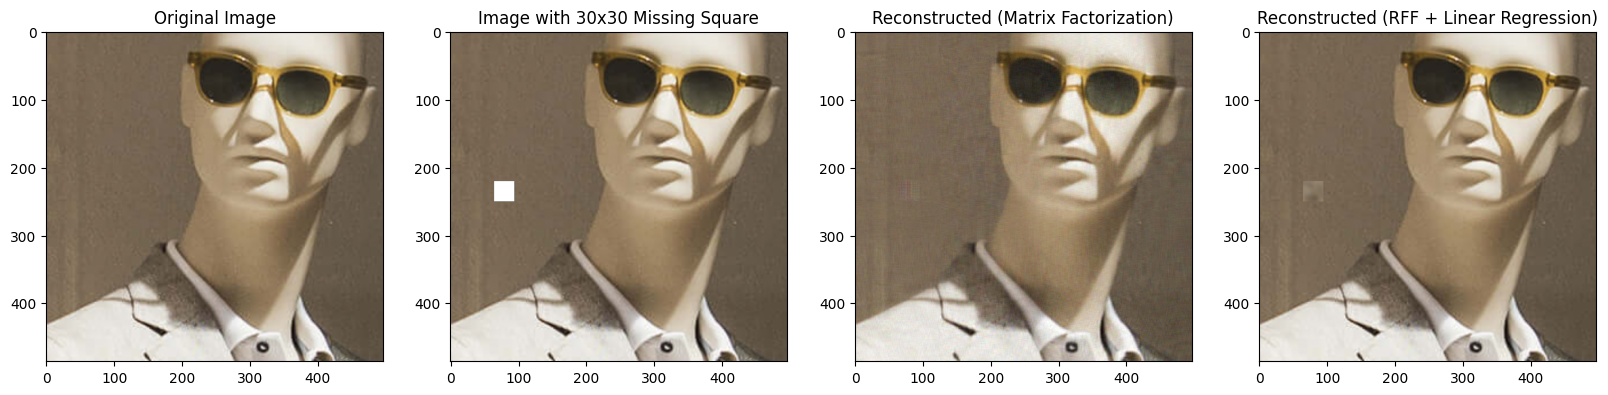

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_path = '/kaggle/input/sampleimage/Screenshot 2024-09-16 153207.png'
img = torchvision.io.read_image(img_path).float() / 255.0  # Normalize between 0 and 1

# Move image to the device (shape: Channels x Height x Width)
img = img.to(device)

# Get height and width of the image
height, width = img.shape[1], img.shape[2]

# Step 1: Remove a 30x30 square from the image
def remove_square(img, square_size=30):
    h, w = img.shape[1], img.shape[2]
    # Randomly select top-left corner of the square
    top_left_y = np.random.randint(0, h - square_size)
    top_left_x = np.random.randint(0, w - square_size)
    
    # Create a mask with the 30x30 square missing
    mask = np.ones((h, w))
    mask[top_left_y:top_left_y + square_size, top_left_x:top_left_x + square_size] = 0
    
    return mask, (top_left_y, top_left_x)

# Generate the mask and get the square coordinates
missing_mask, square_coords = remove_square(img.cpu().numpy())
top_left_y, top_left_x = square_coords

# Apply the mask to the image
img_masked = img.clone()
for c in range(img.shape[0]):  # Loop over RGB channels
    img_masked[c, :, :] *= torch.tensor(missing_mask).to(device)

# Define the matrix factorization function
def factorize_channel(channel, mask, r, lr=0.01, num_iters=7000):
    h, w = channel.shape

    # Initialize W (h x r) and H (r x w) randomly
    W = torch.randn(h, r, requires_grad=True, device=device)
    H = torch.randn(r, w, requires_grad=True, device=device)

    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=lr)

    # Train the model
    for i in range(num_iters):
        optimizer.zero_grad()

        # Reconstructed image
        reconstructed_channel = torch.mm(W, H)

        # Apply mask: consider only the known pixels during training
        loss = torch.norm((reconstructed_channel - channel) * mask, 'fro') ** 2

        # Backpropagation
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")

    return W, H

# Factorize each channel using the masked image
reconstructed_channels_mf = []

for c in range(img.shape[0]):
    channel = img[c, :, :]
    mask = torch.tensor(missing_mask).to(device)  # Use the mask for missing pixels
    W, H = factorize_channel(channel, mask, r=250)
    reconstructed_channel = torch.mm(W, H).cpu().detach().numpy()
    reconstructed_channels_mf.append(reconstructed_channel)

# Stack the reconstructed channels back into an RGB image (Matrix Factorization)
reconstructed_img_mf = np.stack(reconstructed_channels_mf, axis=0)
reconstructed_img_mf = np.clip(reconstructed_img_mf, 0, 1)  # Clip to valid range
reconstructed_img_mf = np.transpose(reconstructed_img_mf, (1, 2, 0))

# Step 2: Random Fourier Features (RFF) + Linear Regression
def rff_reconstruct(img, mask, square_coords, square_size=30, gamma=0.05, n_components=1000):
    """Reconstruct missing pixels using RFF + Linear Regression."""
    top_left_y, top_left_x = square_coords
    X_known = np.argwhere(mask == 1)
    X_missing = np.argwhere(mask == 0)

    # Flatten image for easy access
    img_flattened = img.reshape(img.shape[0], -1)

    reconstructed_channels_rff = []

    for c in range(img.shape[0]):  # Loop over channels (R, G, B)
        y_known = img_flattened[c, X_known[:, 0] * width + X_known[:, 1]]

        # Apply RFF to known pixel positions
        rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=1)
        X_transformed = rbf_feature.fit_transform(X_known)
        X_missing_transformed = rbf_feature.transform(X_missing)

        # Train linear regression
        model = Ridge(alpha=1.0)
        model.fit(X_transformed, y_known)

        # Predict missing pixel values
        y_missing = model.predict(X_missing_transformed)

        # Reconstruct image
        img_reconstructed = img_flattened[c, :].copy()
        img_reconstructed[X_missing[:, 0] * width + X_missing[:, 1]] = y_missing
        reconstructed_channels_rff.append(img_reconstructed.reshape(height, width))

    reconstructed_img_rff = np.stack(reconstructed_channels_rff, axis=0)
    return np.clip(reconstructed_img_rff, 0, 1)  # Clip to valid range

reconstructed_img_rff = rff_reconstruct(img_masked.cpu().numpy(), missing_mask, square_coords)
reconstructed_img_rff = np.transpose(reconstructed_img_rff, (1, 2, 0))

# RMSE and PSNR calculations
def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    max_pixel = 1.0  # Since the image is normalized between 0 and 1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Convert original image to CPU for RMSE/PSNR calculations
original_img = img.cpu().detach().numpy()
original_img = np.transpose(original_img, (1, 2, 0))

# Calculate RMSE and PSNR for Matrix Factorization
rmse_mf = calculate_rmse(original_img, reconstructed_img_mf)
psnr_mf = calculate_psnr(original_img, reconstructed_img_mf)

# Calculate RMSE and PSNR for RFF + Linear Regression
rmse_rff = calculate_rmse(original_img, reconstructed_img_rff)
psnr_rff = calculate_psnr(original_img, reconstructed_img_rff)

print(f"Matrix Factorization - RMSE: {rmse_mf}, PSNR: {psnr_mf} dB")
print(f"RFF + Linear Regression - RMSE: {rmse_rff}, PSNR: {psnr_rff} dB")

# Plot the original, masked, and reconstructed images
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(np.transpose(img_masked.cpu().detach().numpy(), (1, 2, 0)))
ax[1].set_title('Image with 30x30 Missing Square')
ax[2].imshow(reconstructed_img_mf)
ax[2].set_title('Reconstructed (Matrix Factorization)')
ax[3].imshow(reconstructed_img_rff)
ax[3].set_title('Reconstructed (RFF + Linear Regression)')
plt.show()


in previous code we worked with 900 randomly removed pixels, but here we remoed it in a path, here also RFF performs better then Matrix factorization. Also this is when pixels are removed where image was nearly consistent, so this result can differ when image pattern differs. 